In [1]:
import hyperopt
print("hyperopt.__version__", hyperopt.__version__)
import sklearn
print("sklearn.__version__", sklearn.__version__)
#pip install scikit-learn==1.0.2  다운그레이드 해서 테스트하기
import pandas
print("pandas.__version__", pandas.__version__)
#pip install pandas==1.3.5
import xgboost
print("xgboost.__version__", xgboost.__version__)

hyperopt.__version__ 0.2.7
sklearn.__version__ 1.0.2
pandas.__version__ 1.3.5
xgboost.__version__ 1.5.0


In [2]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


# 보팅 분류기

In [3]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)],  # 예측기 여러개 쌓기 
                          voting='soft'  # mean
                          )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=11)


In [4]:
## 학습
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9473684210526315

In [7]:
# 개별  분류기의 예측 성능 - LR, KNN
lr_clf_1 = LogisticRegression(solver='liblinear')

lr_clf_1.fit(X_train, y_train)
lr_pred = lr_clf_1.predict(X_test)
accuracy_score(y_test, lr_pred)

0.9473684210526315

In [8]:
knn_clf_1 = KNeighborsClassifier(n_neighbors=8)

knn_clf_1.fit(X_train, y_train)
knn_pred = knn_clf_1.predict(X_test)
accuracy_score(y_test, knn_pred)

c:\Users\LG\.conda\envs\xgboost_env\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.956140350877193

# 랜덤 포레스트

In [9]:
# 중복 컬럼 이름 정리

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [ ]:
feature_name_df = pd.read_csv('.\UCI HAR Dataset\UCI HAR Dataset\features.txt', sep='\s+',
                              header=None, names=['column_index', 'column_nam'])

new_feature_name_df = get_new_feature_name_df(feature_name_df)

X_train = pd.read_csv('.\UCI HAR Dataset\train/X_train.txt')
X_test = pd.read_csv('.\UCI HAR Dataset\test/X_test.txt')

In [11]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=0, max_depth=8)   # 내부에 결정 트리 가지고 있음 
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy_score(y_test, pred)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3124\690831120.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


0.9195792331184255

# 하이퍼파라미터 튜닝

In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8,16,24],
    'min_samples_split' : [2,8,16],
    'min_samples_leaf' : [1,6,12]
}
                                                                   #병렬처리 
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

c:\Users\LG\.conda\envs\xgboost_env\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [8, 16, 24],
                         'min_samples_leaf': [1, 6, 12],
                         'min_samples_split': [2, 8, 16]})

In [19]:
grid_cv.best_estimator_, grid_cv.best_score_

(RandomForestClassifier(max_depth=16, min_samples_leaf=6, n_jobs=-1,
                        random_state=0),
 0.9164853101196953)

In [20]:
best_model = best_model = grid_cv.best_estimator_
best_pred = best_model.predict(X_test)
accuracy_score(y_test, best_pred)

0.9260264675941635

In [21]:
best_model.feature_importances_

array([9.81575505e-05, 1.71714690e-04, 8.07745255e-05, 4.04825722e-03,
       2.34960400e-04, 2.27512540e-04, 1.88776399e-03, 3.25412882e-04,
       2.70614473e-04, 1.37498179e-02, 1.53772670e-04, 1.42790659e-04,
       1.89725743e-04, 8.40496174e-05, 3.06098762e-04, 2.10614141e-03,
       2.32070576e-03, 2.78605735e-04, 4.07233723e-04, 1.55416034e-03,
       4.80143470e-04, 4.23383990e-04, 9.67043863e-04, 1.74769837e-04,
       3.08823650e-04, 2.26424645e-04, 6.66480063e-05, 6.33247101e-05,
       1.59194002e-04, 1.90456412e-04, 1.21519395e-04, 7.91254197e-05,
       7.13908068e-05, 8.97219641e-05, 7.48107820e-05, 7.02361840e-05,
       2.17973046e-04, 7.11044649e-03, 9.24240060e-04, 4.88302814e-03,
       2.47082604e-02, 3.37286292e-02, 6.63678635e-03, 1.42155557e-03,
       6.02779471e-04, 1.42920846e-04, 3.58092227e-04, 1.57113224e-03,
       3.77948472e-04, 2.75384583e-02, 2.10105066e-02, 1.31245587e-02,
       3.02761205e-02, 2.33393789e-02, 9.23184531e-03, 4.79392814e-03,
      

In [23]:
# 피쳐 중요도 출력
rf_clf_1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                  min_samples_split=2, random_state=0)
rf_clf_1.fit(X_train, y_train)
pred = rf_clf_1.predict(X_test)
print('예측 정확도:{0:.4f}'. format(accuracy_score(y_test, pred)))

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3124\1975068856.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_1.fit(X_train, y_train)


예측 정확도:0.9260


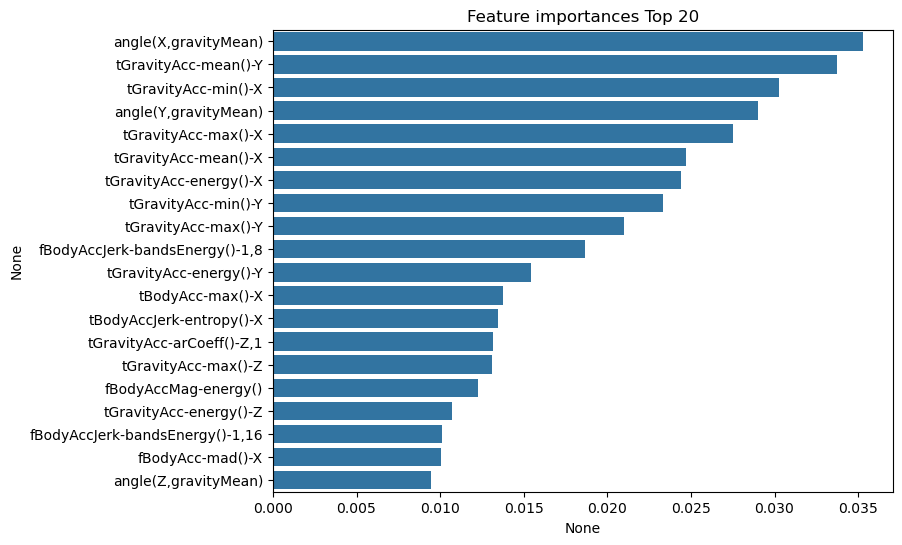

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importance_values = rf_clf_1.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# 부스팅 - GBM
- 정확도는 좋지만, 시간 오래걸림

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
import time

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()  # 수행시간 측정 

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

print(accuracy_score(y_test, gb_pred))
print(f'GBM  수행시간: {time.time() - start_time}')

c:\Users\LG\.conda\envs\xgboost_env\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9389209365456397
GBM  수행시간: 1009.7139911651611


# 부스팅 - XGBoost
- 결정트리 기반
- 속도, 성능 뛰어남 
- 별개의 외부 라이브러리

In [30]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

In [27]:
import pandas as pd

df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [32]:
df['target'] = y_label
df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

### Python native XGBoost

In [33]:
X_features = df.iloc[:, :-1]
y_label = df.iloc[:, -1]

In [34]:
# 전체 > 훈련8 : 시험2
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 훈련 > 훈련9 : 검증1
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [35]:
# xgboost 사용 가능하게 바꿔줌 
dtr = xgb.DMatrix(data=X_tr, label=y_tr) # 훈련용
dval = xgb.DMatrix(data=X_val, label=y_val) # 검증용
dtest = xgb.DMatrix(data=X_test, label=y_test) # 테스트용

In [36]:
# XGB의 하이퍼파라미터 설정 
params = {
    'max_depth': 3,
    'eta': 0.05,  # 학습율 (나누어서)
    'objective': 'binary:logistic',  # 최적화 알고리즘 
    'eval_metric': 'logloss'  # 손실함수 
}
num_rounds = 400   # 최종라운드 

In [37]:
# 평가 데이터 셋
eval_list = [(dtr, 'train'), (dval, 'eval')]

# 예측기에 훈련셋 넣어주기 
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds,
                      early_stopping_rounds=50,  # 조기 종료 
                      evals=eval_list)  # 검증 데이터셋 

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [38]:
# 예측 결과 확율 
pred_prods = xgb_model.predict(dtest)
pred_prods

array([0.8447872 , 0.00842587, 0.6796298 , 0.08113331, 0.9751338 ,
       0.9988939 , 0.9983084 , 0.9980654 , 0.99637896, 0.00138468,
       0.00252283, 0.00154995, 0.99780875, 0.99829525, 0.99691856,
       0.9965521 , 0.99120796, 0.9982718 , 0.9970682 , 0.9978916 ,
       0.00202923, 0.10774372, 0.00137198, 0.9989255 , 0.00107862,
       0.7800014 , 0.00295459, 0.00154995, 0.9966723 , 0.05379276,
       0.958738  , 0.00149019, 0.9700533 , 0.8656249 , 0.00678389,
       0.00140975, 0.97810876, 0.99713576, 0.24059245, 0.9972307 ,
       0.35760084, 0.99708337, 0.9919429 , 0.99659145, 0.9962838 ,
       0.9179466 , 0.036952  , 0.997417  , 0.99325067, 0.99804085,
       0.99648905, 0.00236221, 0.9979361 , 0.99784875, 0.9960328 ,
       0.99391055, 0.9984106 , 0.99635327, 0.9967404 , 0.896291  ,
       0.9967794 , 0.9520696 , 0.00349248, 0.00202715, 0.9980167 ,
       0.98225844, 0.00349248, 0.99056447, 0.9972249 , 0.9978916 ,
       0.00297725, 0.99731344, 0.00163038, 0.98887384, 0.99624

In [40]:
# 이진분류 - 예측 클래스 값 
preds = [ 1 if x > 0.5 else 0 for x in pred_prods]
preds[:10]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_prods=None):
    confusion = confusion_matrix(y_test, pred)
    accuarcy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print(confusion)
    print('*'*20)
    print(accuarcy, precision, recall, f1, roc_auc)

In [42]:
get_clf_eval(y_test, preds, pred_prods)

[[34  3]
 [ 2 75]]
********************
0.956140350877193 0.9615384615384616 0.974025974025974 0.967741935483871 0.9464724464724464


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

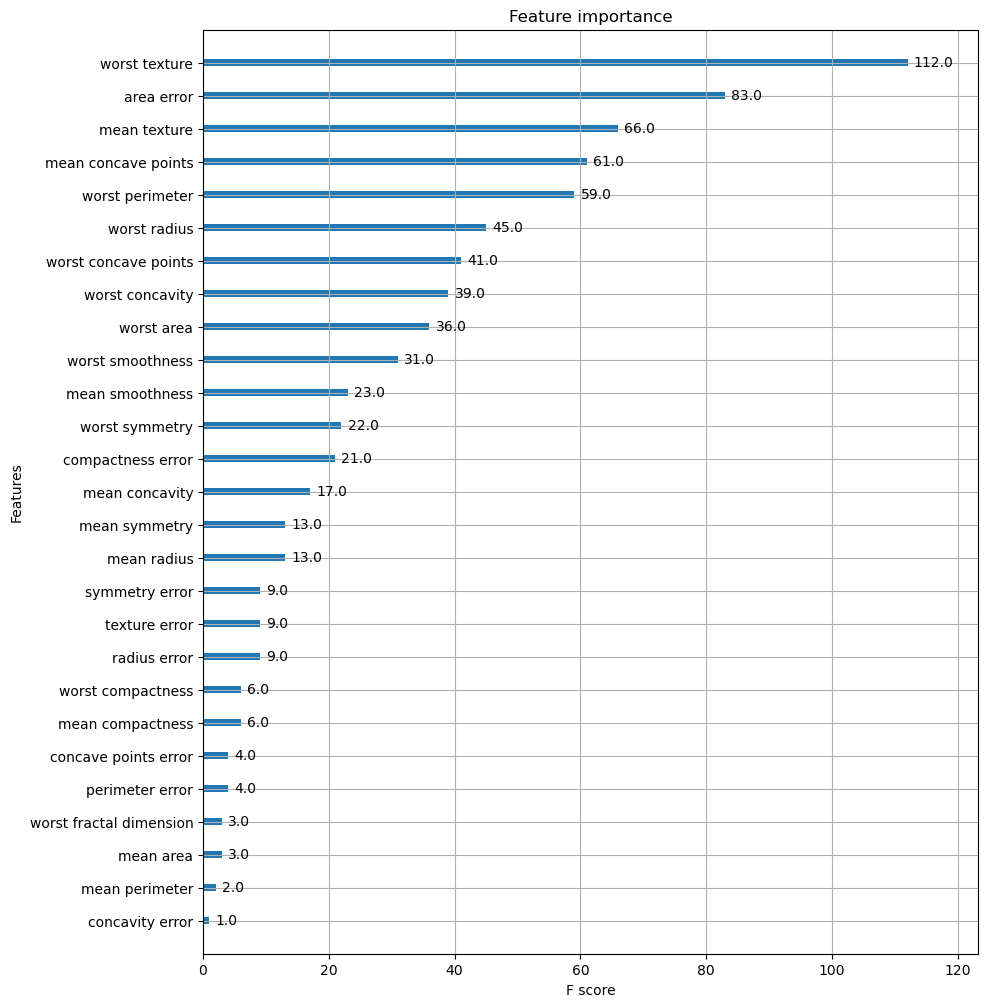

In [43]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

### sklearn.xgboost 

In [44]:
from xgboost import XGBClassifier

In [ ]:
xgb_wrapper_model = XGBClassifier(n_estimators=400, 
                                  learning_rate=0.05, 
                                  max_depth=3
                                  )
xgb_wrapper_model.fit(X_train, y_train)
wr_pred = xgb_wrapper_model.predict(X_test)
wr_pred_proba= xgb_wrapper_model.predict_proba(X_test)

get_clf_eval(y_test, wr_pred, wr_pred_proba)

c:\Users\LG\.conda\envs\xgboost_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:18:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[34  3]
 [ 1 76]]
********************
0.9649122807017544 0.9620253164556962 0.987012987012987 0.9743589743589742 0.9529659529659528


# LGBM

In [1]:
from lightgbm import LGBMClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

dataset = load_breast_cancer()
cancer_df = pd.DataFrame(data = dataset.data, columns= dataset.feature_names)
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
X_features = dataset.data
y_label = dataset.target

# 1단계 
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2 ,random_state=156)

# 2단계
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)


## LGBM 모델 생성

In [6]:
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

## 훈련 

In [7]:
# 훈련 / 검증 용 데이터 평가 목록 
eval_list = [(X_tr, y_tr), (X_val, y_val)]

# early stopping 
lgbm_wrapper.fit(X_tr, y_tr, 
                 early_stopping_rounds=50,
                 eval_metric='logloss',
                 eval_set= eval_list,
                 verbose=True  
                 )


c:\Users\LG\.conda\envs\xgboost_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\LG\.conda\envs\xgboost_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

LGBMClassifier(learning_rate=0.05, n_estimators=400)

## 예측 

In [11]:
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, preds, pred_proba)

[[34  3]
 [ 2 75]]
********************
0.956140350877193 0.9615384615384616 0.974025974025974 0.967741935483871 0.9464724464724464


## 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

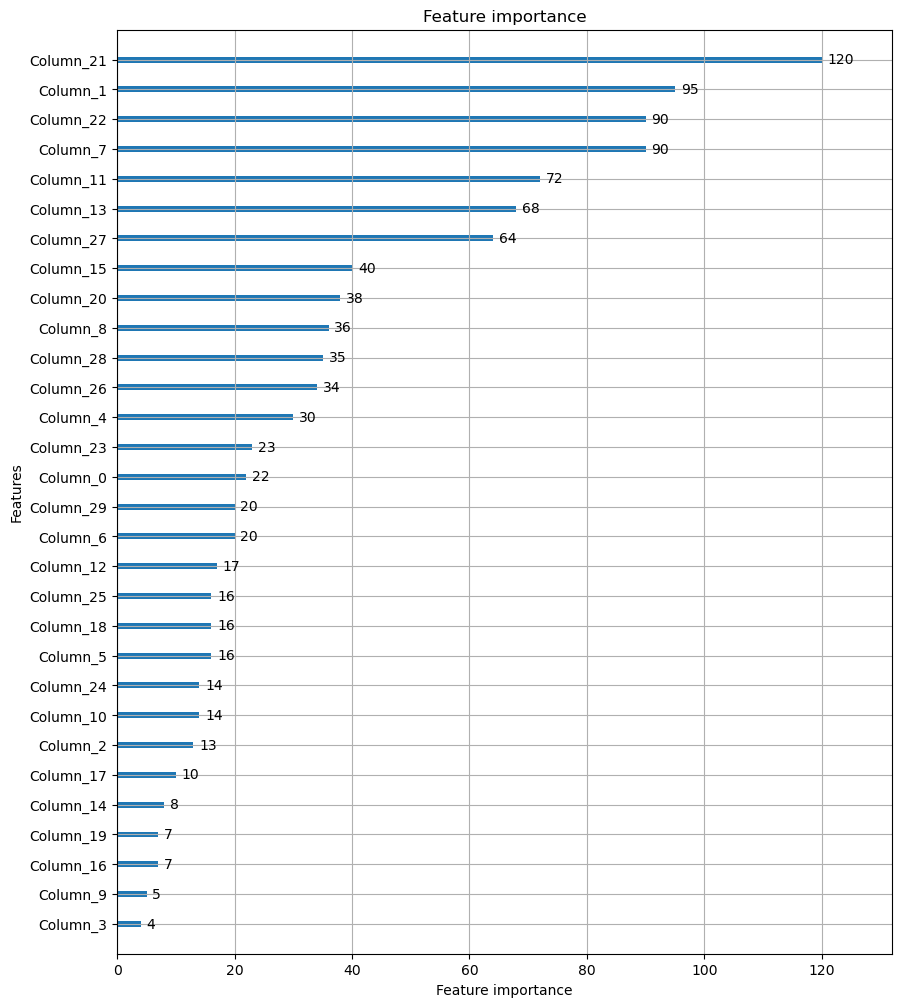

In [13]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)